In [1]:
import matplotlib
matplotlib.use("qt4agg")
from bitfinex.backtest import data
from bitfinex import Client, TradeClient
import wget
import holoviews as hv

%pylab inline

/usr/local/lib/python3.4/dist-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


Populating the interactive namespace from numpy and matplotlib


In [2]:
import backtrader
import pandas as pd
hv.notebook_extension('matplotlib')

In [3]:
TC = TradeClient()
C = Client()

Let's Start by checking my balances:

In [4]:
bals = pd.DataFrame(TC.balances())
bals

B8eDkYvz86TcvGZYuNBc2i9M6dgYe5kYWm71ceeU1W1 d457e5f0d8fce6d616569708d9da45f06f0213f7ff76bf02e0d8fd4e40faaae66919c08c5426e1c5718a423aa6f02d3a


,amount,available,currency,type
0,0.0,0.0,usd,deposit
1,3.7924038,3.7924038,btc,exchange
2,0.01569268,0.01569268,usd,exchange
3,0.0,0.0,btc,trading
4,0.0,0.0,usd,trading


Let's Download some historic series:

In [7]:
wget.download('http://api.bitcoincharts.com/v1/csv/bitfinexUSD.csv.gz','bitfinexUSD.csv.gz')

TypeError: 'str' object is not callable

In [8]:
history = data.CSVDataSource('bitfinexUSD.csv.gz',fields=['datetime', 'price', 'volume'])
history.parse_timestamp_column('datetime',unit='s')


In [9]:
print(history.data.info())
history.data.describe()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8003556 entries, 2013-03-31 22:07:48 to 2016-03-06 11:48:05
Data columns (total 2 columns):
price     float64
volume    float64
dtypes: float64(2)
memory usage: 183.2 MB
None


,price,volume
count,8.003556e+06,8.003556e+06
mean,3.725905e+02,2.649395e+00
std,1.686552e+02,9.483050e+00
min,1.000000e-02,1.000000e-08
25%,2.479500e+02,9.600697e-02
50%,3.400000e+02,5.000000e-01
75%,4.360000e+02,2.000000e+00
max,1.175000e+03,2.333891e+03


Fake open, high, low, close data

In [10]:
history.data['open'] = history.data.price
history.data['high'] = history.data.price
history.data['low'] = history.data.price
history.data['close'] = history.data.price
history.data[:10]

,price,volume,open,high,low,close
datetime,,,,,,
2013-03-31 22:07:48,93.25,12.671482,93.25,93.25,93.25,93.25
2013-03-31 22:07:49,93.30,80.628518,93.30,93.30,93.30,93.30
2013-03-31 22:08:13,100.00,20.000000,100.00,100.00,100.00,100.00
2013-03-31 22:08:14,100.00,1.000000,100.00,100.00,100.00,100.00
2013-03-31 22:08:16,100.00,5.900000,100.00,100.00,100.00,100.00
2013-03-31 22:08:19,100.00,29.833879,100.00,100.00,100.00,100.00
2013-03-31 22:08:21,100.00,20.000000,100.00,100.00,100.00,100.00
2013-03-31 22:08:25,100.00,10.000000,100.00,100.00,100.00,100.00
2013-03-31 22:08:29,100.00,1.000000,100.00,100.00,100.00,100.00


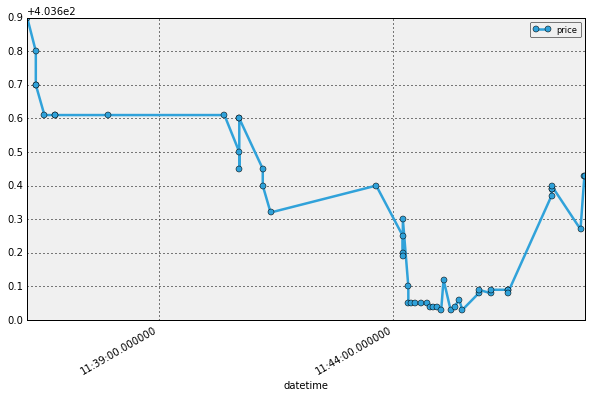

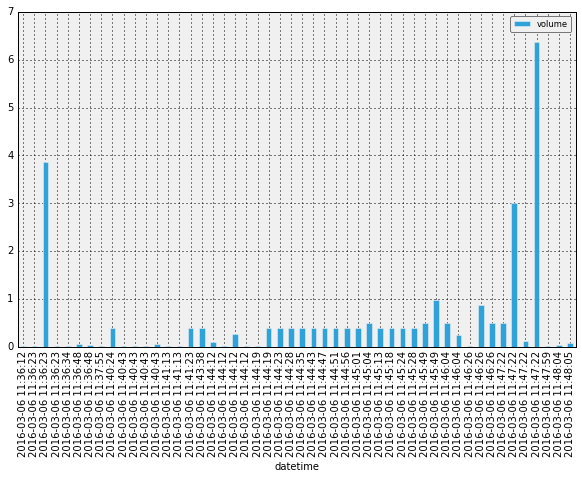

In [11]:
history.data[-50:].plot(y='price',figsize=(10,6), style='-o', grid=True);
history.data[-50:].plot(y='volume', kind='bar',figsize=(10,6), grid=True);

Creating a strategy

In [12]:
import backtrader.indicators as btind
import backtrader.analyzers as btanalyzers

In [13]:
def run_test():
    print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())
    res = cerebro.run()
    print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())
    return res

In [15]:
class SMA_CrossOver(backtrader.Strategy):

    params = (('fast', 12), ('slow', 26))

    def __init__(self):
        self.rsi = btind.RSI()
        sma_fast = btind.SMA(period=self.p.fast)
        sma_slow = btind.SMA(period=self.p.slow)

        self.buysig = btind.CrossOver(sma_fast, sma_slow)

    def next(self):
        if self.position.size:
#             if (self.buysig < 0):
#                 self.sell()

#       elif (self.buysig > 0):
#                 self.buy()
            if (self.rsi<=50):
                self.sell()

        elif (self.rsi>=60):
            self.buy()
            
class Aroon(backtrader.Strategy):
    params = (('period',70),)
    def __init__(self):
        self.a_up = btind.AroonUp(period=self.p.period)
        self.a_down = btind.AroonDown(period=self.p.period)
    def next(self):
        if self.position.size:
            if self.a_down >= 95:
                self.sell()
        elif self.a_up >=97:
            self.buy()

In [68]:
class MarcosStrat(backtrader.Strategy):
    def __init__(self):
        self.delta = 2
        self.price_in = None
        self.price_out = 100000
        self.trailing = 0.5
        self.target = 10000000
    def next(self):
        self.price_out = self.data.close[0] if self.price_out is None else self.price_out
        if self.position.size:
            #self.price_in = self.data.close[0] if self.price_in is None else self.price_in
            print("Sell. Price: {}, price_out: {}, price_in:{}".format(self.data.close[0],self.price_out, self.price_in))
            if self.data.close[0] - self.price_in >= self.delta:
                #self.target =  self.data.close-self.trailing if self.data.close > self.target else self.target 
                #if self.data.close <= self.target:
                self.sell()
                self.price_out = self.data.close[0]
        elif self.data.close[0] - self.price_out <= -self.delta:
            
            print("{}.Price: {}, price_out: {}, price_in:{}".format(self.position.size,self.data.close[0],self.price_out, self.price_in))
            
            #self.target =  self.data.close+self.trailing if self.data.close < self.target else self.target 
            #if self.data.close >= self.target:
            self.buy()
            self.price_in = self.data.close[0]
                

In [72]:
cerebro = backtrader.Cerebro()
cerebro.broker.setcash(100000.0)
data2 = backtrader.feeds.PandasData(dataname=history.data[-50000:], datetime=None)
cerebro.adddata(data2)
cerebro.broker.setcommission(commission=0.001)
# cerebro.addstrategy(SMA_CrossOver)
cerebro.addstrategy(MarcosStrat)
#cerebro.addanalyzer(btanalyzers.SharpeRatio, _name='mysharpe')
res = run_test()
#print('Sharpe Ratio:', res[0].analyzers.mysharpe.get_analysis())

Starting Portfolio Value: 100000.00
0.Price: 436.7, price_out: 100000, price_in:None
Sell. Price: 436.7, price_out: 100000, price_in:436.7
Sell. Price: 436.7, price_out: 100000, price_in:436.7
Sell. Price: 436.7, price_out: 100000, price_in:436.7
Sell. Price: 436.7, price_out: 100000, price_in:436.7
Sell. Price: 436.7, price_out: 100000, price_in:436.7
Sell. Price: 436.7, price_out: 100000, price_in:436.7
Sell. Price: 436.7, price_out: 100000, price_in:436.7
Sell. Price: 436.7, price_out: 100000, price_in:436.7
Sell. Price: 436.7, price_out: 100000, price_in:436.7
Sell. Price: 436.7, price_out: 100000, price_in:436.7
Sell. Price: 436.7, price_out: 100000, price_in:436.7
Sell. Price: 436.7, price_out: 100000, price_in:436.7
Sell. Price: 436.69, price_out: 100000, price_in:436.7
Sell. Price: 436.7, price_out: 100000, price_in:436.7
Sell. Price: 436.7, price_out: 100000, price_in:436.7
Sell. Price: 436.7, price_out: 100000, price_in:436.7
Sell. Price: 436.7, price_out: 100000, price_in:43

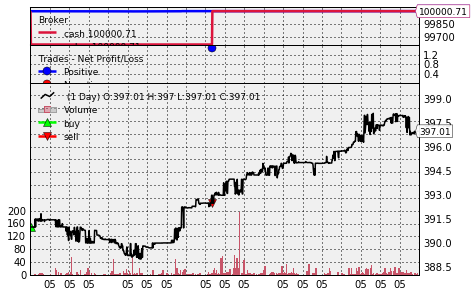

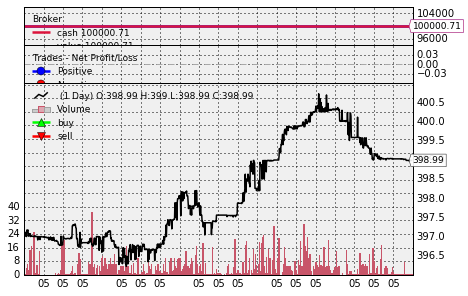

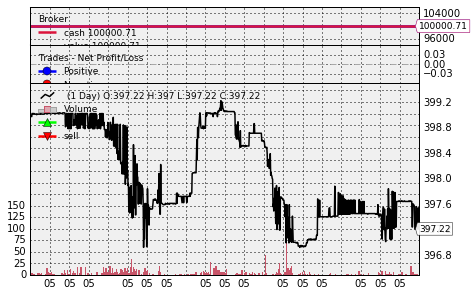

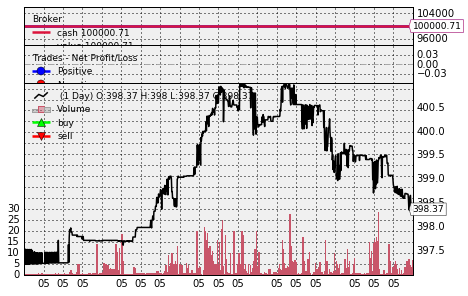

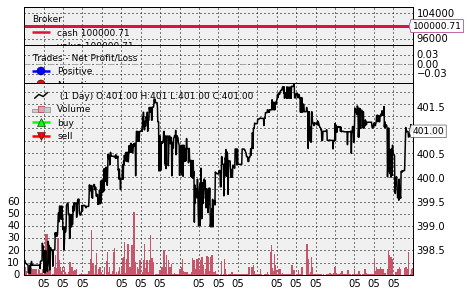

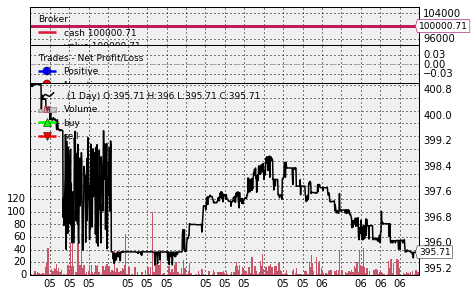

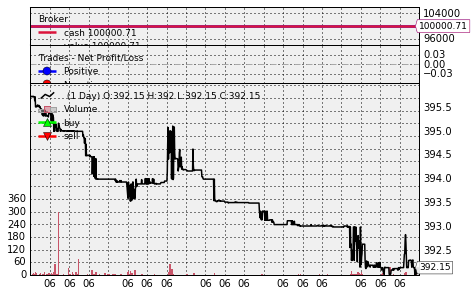

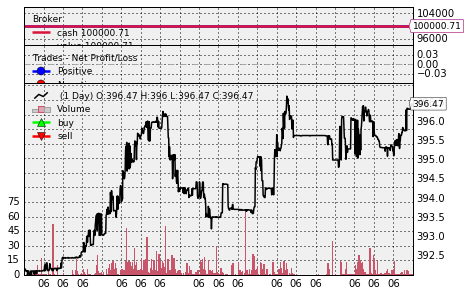

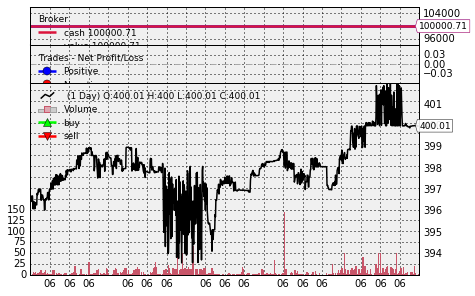

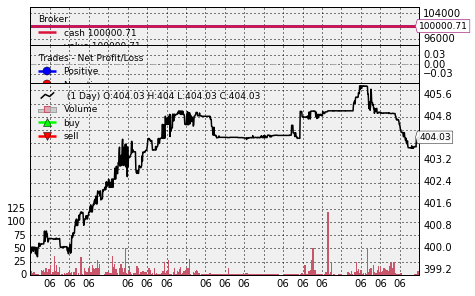

In [70]:
cerebro.plot(numfigs=10)

In [86]:
btind.AroonUp?

In [ ]:
LinePlotterIndicator(close_over_sma, name='Close_over_SMA)